In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load electricity and hydrogen results

In [131]:
elec_results_path = './results/electricity_prod_results_no_learning_MidCase_2024.xlsx'
def load_elec_results(elec_results_path, industry_tag, industry_name):
  ind_df = pd.read_excel(elec_results_path, sheet_name=industry_tag)
  ind_df['Ind'] = industry_name
  ind_df.set_index(['id', 'Ind'])
  return ind_df



In [132]:
industries = {'ammonia':'H2 Ammonia', 'process_heat':'H2 Process Heat', 'refining': 'H2 Refining', 'steel':'H2 Steel-making'}
to_concat_elec = []
to_concat_h2 = []
for ind_tag, ind_name in industries.items():
  temp_df_elec = load_elec_results(elec_results_path, ind_tag, ind_name)
  temp_df_h2 = load_elec_results(elec_results_path, ind_tag, ind_name)
  temp_df_h2['Hydrogen revenues (M$/year/MWe)'] = temp_df_h2.apply(lambda x:x['Avoided fossil fuel cost (M$/year/MWe)']+x['H2 PTC revenues (M$/year/MWe)'], axis=1)
  to_concat_elec.append(temp_df_elec)
  to_concat_h2.append(temp_df_h2)
elec_df = pd.concat(to_concat_elec)
h2_df = pd.concat(to_concat_h2)

### Compute net annual revenues for electricity production

In [133]:
elec_df['Net Revenues (M$/year/MWe)'] = elec_df.apply(lambda x:x['Electricity sales (M$/year/MWe)'] - (x['ANR CAPEX ($/year)']+x['ANR O&M ($/year)'])/(x['Depl. ANR Cap. (MWe)']*1e6), axis=1)
elec_df['Application'] = 'Electricity'

In [134]:
h2_df['Net Revenues (M$/year/MWe)'] = h2_df.apply(lambda x:x['Hydrogen revenues (M$/year/MWe)']+x['Net Revenues ($/year)']/(x['Depl. ANR Cap. (MWe)']*1e6), axis=1)
# Net Revenues existing columns correspond only to h2 and anr capex and o&m costs
h2_df['Application'] = 'Industrial Hydrogen'

# Load direct heat results

In [135]:
heat_df = pd.read_csv('./results/direct_heat_maxv_results.csv', header=0)
# Filter out results with cogeneration

anrs_params = pd.read_excel('./ANRs.xlsx')[['Reactor', 'Power in MWe']]
anrs_params.replace({'Micro':'Microreactor'}, inplace=True)
heat_df = heat_df.merge(anrs_params, left_on='Generator', right_on='Reactor')
heat_df['Depl. ANR Cap. (MWe)'] = heat_df.apply(lambda x: x['Power in MWe']*x['Modules'], axis=1)

In [136]:
heat_df['Net Revenues (M$/year/MWe)'] = heat_df.apply(lambda x:x['Net Annual Revenues (M$/y)']/x['Depl. ANR Cap. (MWe)'], axis=1)
heat_df_nocogen = heat_df[heat_df['cogen']==False]
heat_df_nocogen['Application'] = 'Direct Process Heat'
heat_df_cogen = heat_df[heat_df['cogen']==True]
heat_df_cogen['Application'] = 'Cogeneration,\n Direct Process Heat\nand Electricity'

C:\Users\mgarrou\AppData\Local\Temp\ipykernel_11192\2513086518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df_nocogen['Application'] = 'Direct Process Heat'
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_11192\2513086518.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df_cogen['Application'] = 'Cogeneration,\n Direct Process Heat\nand Electricity'


# Plot and save all results

In [139]:
total_data = pd.concat([heat_df_cogen, heat_df_nocogen, h2_df, elec_df])
total_data.replace({'Micro':'Microreactor'}, inplace=True)

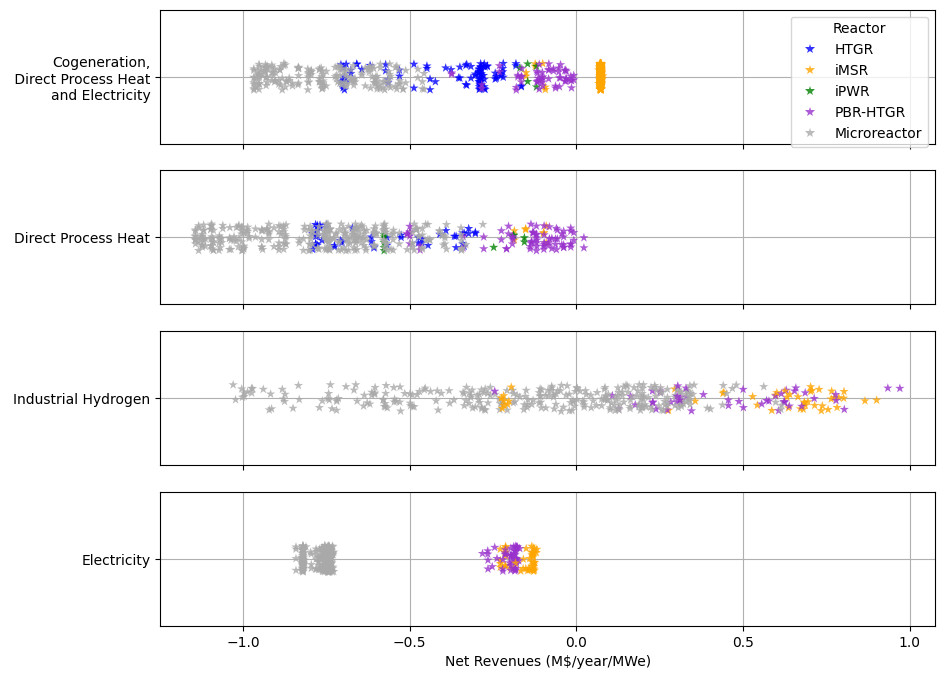

In [161]:
fig, ax = plt.subplots(4,1, sharex=True, figsize=(10,8))
applications = ['Cogeneration,\n Direct Process Heat\nand Electricity', 'Direct Process Heat', 'Industrial Hydrogen', 'Electricity']
count = 0
palette={'HTGR':'blue', 'iMSR':'orange', 'iPWR':'green', 'PBR-HTGR':'darkorchid', 'Microreactor':'darkgrey'}
for app in applications:
  sns.stripplot(ax=ax[count], data=total_data[total_data['Application']==app], x='Net Revenues (M$/year/MWe)', y='Application',\
                palette=palette, hue='Reactor', marker='*', size=7, alpha=0.8)
  if count !=0:
    ax[count].get_legend().set_visible(False)
  ax[count].set_ylabel('')
  ax[count].grid(True)
  count +=1
plt.savefig('./results/ANR_application_comparison.png')